In [1]:
library(monocle)
library(dplyr)

load(file = "./SingleCell-S4.RData")  # load data
SubCellDataSet=merge[[2]]
CellDataSet=merge[[1]]

Loading required package: Matrix
Loading required package: Biobase
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:Matrix’:

    colMeans, colSums, rowMeans, rowSums, which

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colMeans, colnames,
    colSums, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, lengths, Map, mapply, match,
    mget, order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rowMeans, rownames, rowSums, sapply, 

In [3]:
to.show.genes=c("Ccnd1","Ki67","Wnt5a","Wnt5b","Id3","Thbs1","Krt10")

cds.obj=estimateSizeFactors(CellDataSet)
cds.obj=estimateDispersions(cds.obj)
disp_table=dispersionTable(cds.obj)
head(disp_table)

Removing 100 outliers


gene_id,mean_expression,dispersion_fit,dispersion_empirical
0610007P14Rik,8.815368,7.958439,4.770843
0610009B22Rik,6.721678,9.970197,4.020173
0610009O20Rik,4.706247,13.597610,15.164023
0610011F06Rik,10.126748,7.122066,6.408486
0610012G03Rik,25.415809,3.739951,2.908478
0610030E20Rik,11.751126,6.344891,11.143098


In [4]:
pData(cds.obj)$res.0.4=NULL
pData(cds.obj)$res.0.8=NULL
pData(cds.obj)$Cluster=pData(cds.obj)$res.0.6

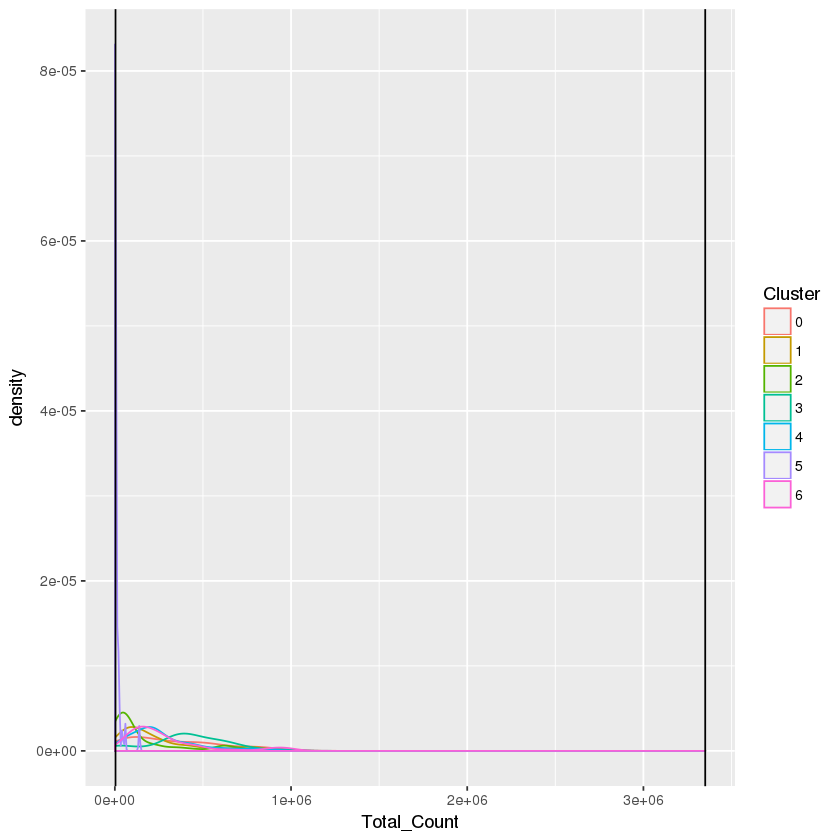

In [5]:
pData(cds.obj)$Total_Count <- Matrix::colSums(exprs(cds.obj))
cds.obj <- cds.obj[,pData(cds.obj)$Total_Count < 1e6]
upper_bound <- 10^(mean(log10(pData(cds.obj)$Total_Count)) +
                     2*sd(log10(pData(cds.obj)$Total_Count)))
lower_bound <- 10^(mean(log10(pData(cds.obj)$Total_Count)) -
                     2*sd(log10(pData(cds.obj)$Total_Count)))


qplot(Total_Count, data = pData(cds.obj), color = Cluster, geom = "density") +
  geom_vline(xintercept = lower_bound) +
  geom_vline(xintercept = upper_bound)

#### 这里看看基因的表达量和基因的变异度之间的关系, 处在灰色阴影区域的基因会被抛弃掉，不进入聚类分析。

Warning message:
“Transformation introduced infinite values in continuous y-axis”

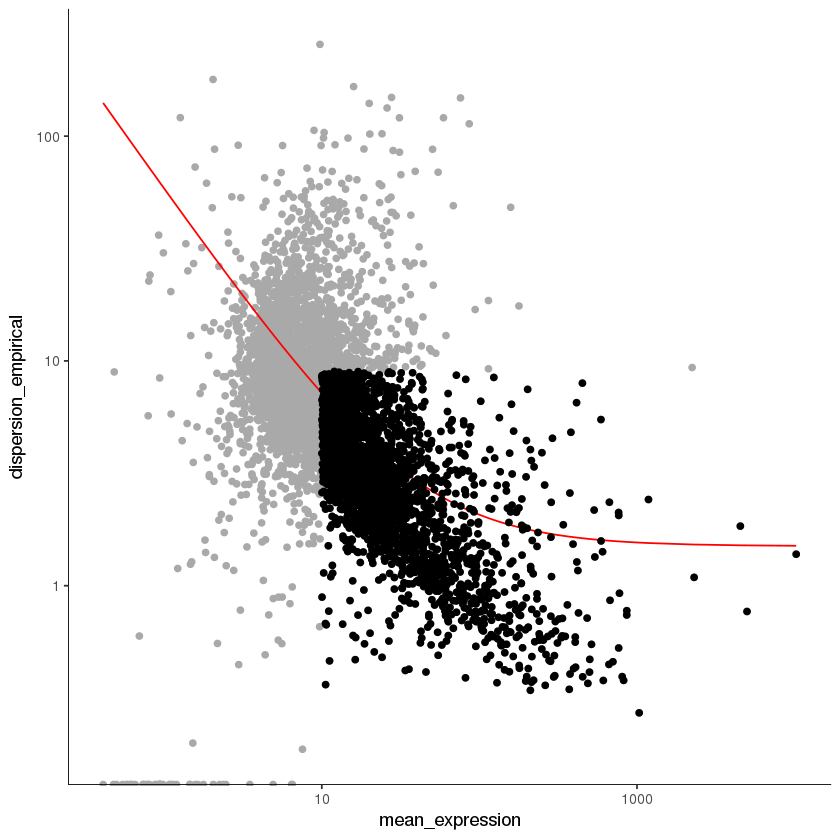

In [6]:
unsup_clustering_genes=subset(disp_table,mean_expression>=10.0 & dispersion_empirical<=9.0)
cds.obj.hg=setOrderingFilter(cds.obj,ordering_genes = unsup_clustering_genes$gene_id)
plot_ordering_genes(cds.obj.hg)

#### 差异分析

In [7]:
#marker_genes <- row.names(subset(fData(cds.obj.hg), 
#                                 gene_short_name %in% genes))

#diff_test_res <- differentialGeneTest(cds.obj.hg[marker_genes,], 
#                                      fullModelFormulaStr="~res.0.1")

diff_test_res=differentialGeneTest(cds.obj.hg,fullModelFormulaStr = "~Cluster")

In [8]:
# Select genes that are significant at an FDR < 10%
sig_genes <- subset(diff_test_res, qval < 0.1)
head(sig_genes[,c("gene_short_name", "pval", "qval")])

,gene_short_name,pval,qval
0610007P14Rik,0610007P14Rik,3.007691e-03,7.872435e-03
0610011F06Rik,0610011F06Rik,3.222565e-02,6.010563e-02
0610030E20Rik,0610030E20Rik,3.697986e-03,9.403905e-03
1110004E09Rik,1110004E09Rik,7.372577e-03,1.706912e-02
1110008P14Rik,1110008P14Rik,4.249476e-09,3.160400e-08
1110012L19Rik,1110012L19Rik,7.958205e-15,1.028579e-13


Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Removed 936 rows containing non-finite values (stat_summary).”Warning message:
“Removed 936 rows containing non-finite values (stat_summary).”geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?
geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?
geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?
geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?


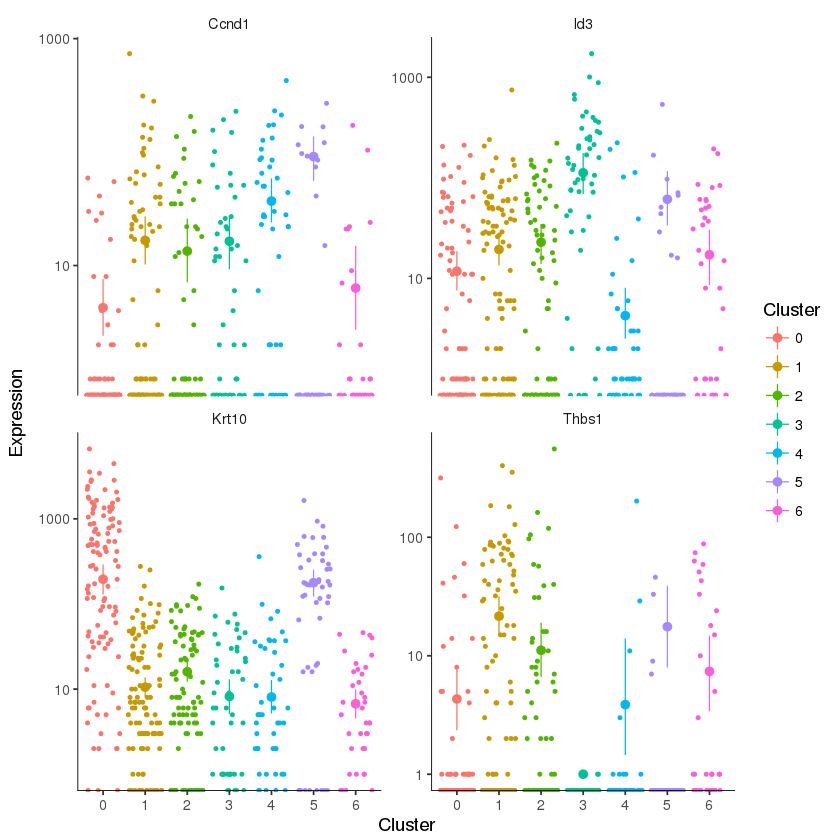

In [9]:
MYOG_ID1 <- cds.obj.hg[row.names(subset(fData(cds.obj.hg), 
                                      gene_short_name %in% to.show.genes)),]
plot_genes_jitter(MYOG_ID1, grouping="Cluster", ncol=2,color_by="Cluster", plot_trend=TRUE)

In [15]:
pData(cds.obj.hg)$State=cds.obj.hg$Cluster #没有这个会报错
cds.obj.hg=reduceDimension(cds = cds.obj.hg,max_components = 2,reduction_method = "DDRTree",verbose =FALSE)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


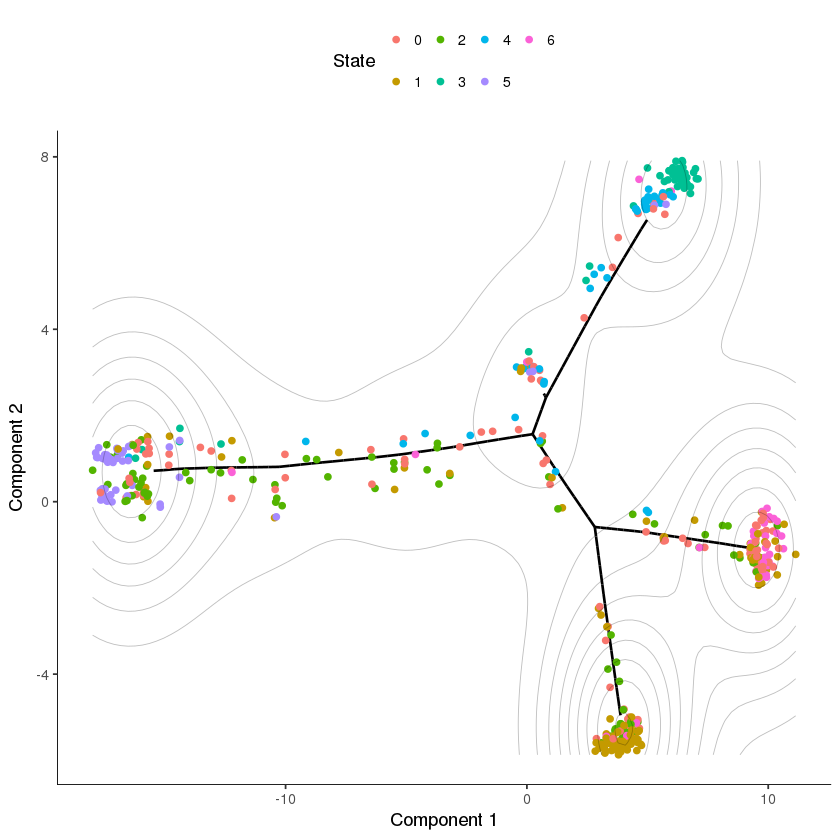

In [16]:
plot_cell_trajectory(cds.obj.hg,
                     color_by = "State",
                     markers_linear = F)+ stat_density2d(color='black', h = 8, alpha=I(0.25), size=I(0.25))

In [18]:
cds.obj.hg=orderCells(cds = cds.obj.hg,root_state = "1",num_paths = 3)  # return  Pseudotime value
cds.obj.hg=clusterCells(cds = cds.obj.hg,num_clusters = 4,method = "DDRTree")

Warning message in max(root_cell_candidates$Pseudotime):
“no non-missing arguments to max; returning -Inf”Warning: num_paths only valid for method 'ICA' in reduceDimension()


Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”

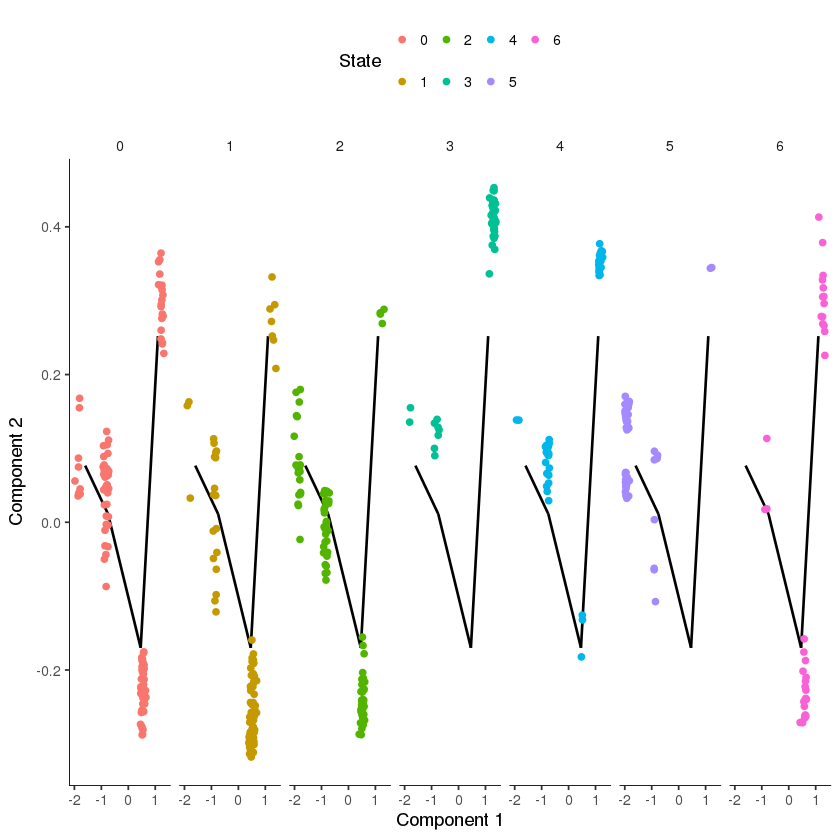

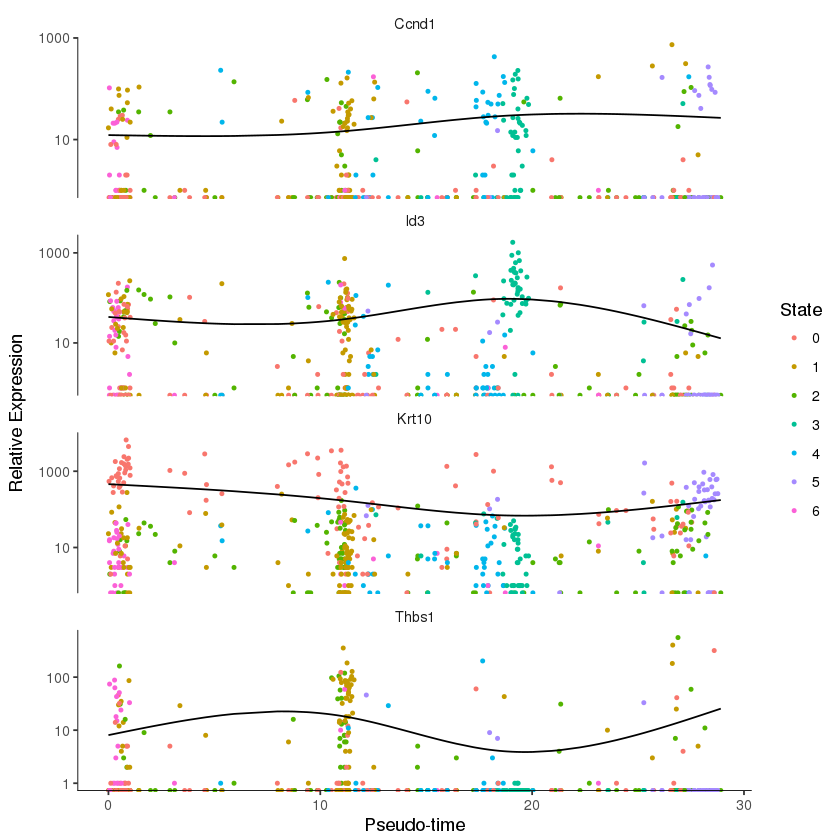

In [19]:
plot_cell_trajectory(cds.obj.hg,
                     #color_by = "State",
                     markers_linear = T)+facet_wrap(~State, nrow = 1)

plot_genes_in_pseudotime(cds_subset = cds.obj.hg[c("Id3","Krt10","Thbs1","Ccnd1"),],color_by = "State")


###  load save object

In [6]:
library(monocle)
source('tools.R')

In [7]:
plot_grid<-function (..., plotlist = NULL, align = c("none", "h", "v", "hv"), 
    axis = c("none", "l", "r", "t", "b", "lr", "tb", "tblr"), 
    nrow = NULL, ncol = NULL, rel_widths = 1, rel_heights = 1, 
    labels = NULL, label_size = 14, label_fontfamily = NULL, 
    label_fontface = "bold", label_colour = NULL, label_x = 0, 
    label_y = 1, hjust = -0.5, vjust = 1.5, scale = 1, cols = NULL, 
    rows = NULL) 
{
    plots <- c(list(...), plotlist)
    num_plots <- length(plots)
    if (!is.null(cols)) {
        warning("Argument 'cols' is deprecated. Use 'ncol' instead.")
    }
    if (!is.null(rows)) {
        warning("Argument 'rows' is deprecated. Use 'nrow' instead.")
    }
    scale <- rep_len(scale, num_plots)
    if (sum(scale <= 0) > 1) {
        stop("Argument 'scale' needs to be greater than 0.")
    }
    if (!is.null(ncol)) {
        cols <- ncol
    }
    if (!is.null(nrow)) {
        rows <- nrow
    }
    grobs <- align_plots(plotlist = plots, align = align, axis = axis)
    if (is.null(cols) && is.null(rows)) {
        cols <- ceiling(sqrt(num_plots))
        rows <- ceiling(num_plots/cols)
    }
    if (is.null(cols)) 
        cols <- ceiling(num_plots/rows)
    if (is.null(rows)) 
        rows <- ceiling(num_plots/cols)
    if ("AUTO" %in% labels) 
        labels <- LETTERS[1:num_plots]
    else if ("auto" %in% labels) 
        labels <- letters[1:num_plots]
    hjust <- rep_len(hjust, length(labels))
    vjust <- rep_len(vjust, length(labels))
    label_x <- rep_len(label_x, length(labels))
    label_y <- rep_len(label_y, length(labels))
    rel_heights <- rep(rel_heights, length.out = rows)
    rel_widths <- rep(rel_widths, length.out = cols)
    x_deltas <- rel_widths/sum(rel_widths)
    y_deltas <- rel_heights/sum(rel_heights)
    xs <- cumsum(rel_widths)/sum(rel_widths) - x_deltas
    ys <- 1 - cumsum(rel_heights)/sum(rel_heights)
    p <- ggdraw()
    col_count <- 0
    row_count <- 1
    for (i in 1:(rows * cols)) {
        if (i > num_plots) 
            break
        x_delta <- x_deltas[col_count + 1]
        y_delta <- y_deltas[row_count]
        x <- xs[col_count + 1]
        y <- ys[row_count]
        p_next <- grobs[[i]]
        if (!is.null(p_next)) {
            p <- p + draw_grob(p_next, x, y, x_delta, y_delta, 
                scale[i])
        }
        if (i <= length(labels)) {
            p <- p + draw_plot_label(labels[i], x + label_x[i] * 
                x_delta, y + label_y[i] * y_delta, size = label_size, 
                family = label_fontfamily, fontface = label_fontface, 
                colour = label_colour, hjust = hjust[i], vjust = vjust[i])
        }
        col_count <- col_count + 1
        if (col_count >= cols) {
            col_count <- 0
            row_count <- row_count + 1
        }
    }
    p
}

In [8]:
load(file = "SingleCellObj.RData")
importCDS(sub.obj,import_all = TRUE)
load("cds.obj.RData")

CellDataSet (storageMode: environment)
assayData: 14124 features, 440 samples 
  element names: exprs 
protocolData: none
phenoData
  sampleNames: P11.1_801501.R2.clean_CGACACAC
    P11.1_801501.R2.clean_TCCGTCTA ... P15_L3_806506.R2.clean_GCTAACGA
    (440 total)
  varLabels: nGene nUMI ... Size_Factor (6 total)
  varMetadata: labelDescription
featureData
  featureNames: 0610007P14Rik 0610009B22Rik ... n-R5s25 (14124 total)
  fvarLabels: gene_short_name
  fvarMetadata: labelDescription
experimentData: use 'experimentData(object)'
Annotation:  

In [3]:
to.show.genes=c("Ccnd1","Ki67","Wnt5a","Wnt5b","Id3","Thbs1","Krt10")

pData(cds.obj)$State<-as.character(as.integer(cds.obj$res.0.8)+1)
cds.obj=estimateSizeFactors(cds.obj)
cds.obj=estimateDispersions(cds.obj)
disp_table=dispersionTable(cds.obj)
head(disp_table)

Removing 286 outliers


gene_id,mean_expression,dispersion_fit,dispersion_empirical
0610007P14Rik,9.34816123,7.835066,3.464530
0610009B22Rik,7.56310250,9.004474,4.515011
0610009L18Rik,0.63211564,76.153332,47.542893
0610009O20Rik,6.02551183,10.567215,15.810055
0610010F05Rik,1.87633731,27.565180,17.564430
0610010K14Rik,0.01369706,3384.407251,0.000000


In [4]:
cds.obj=reduceDimension(cds = cds.obj,max_components = 2,reduction_method = "DDRTree",verbose =FALSE)

In [5]:
cds.obj=orderCells(cds = cds.obj,root_state = "0")  # return  Pseudotime value
cds.obj=clusterCells(cds = cds.obj,num_clusters = 5,method = "DDRTree")

Warning message in max(root_cell_candidates$Pseudotime):
“no non-missing arguments to max; returning -Inf”

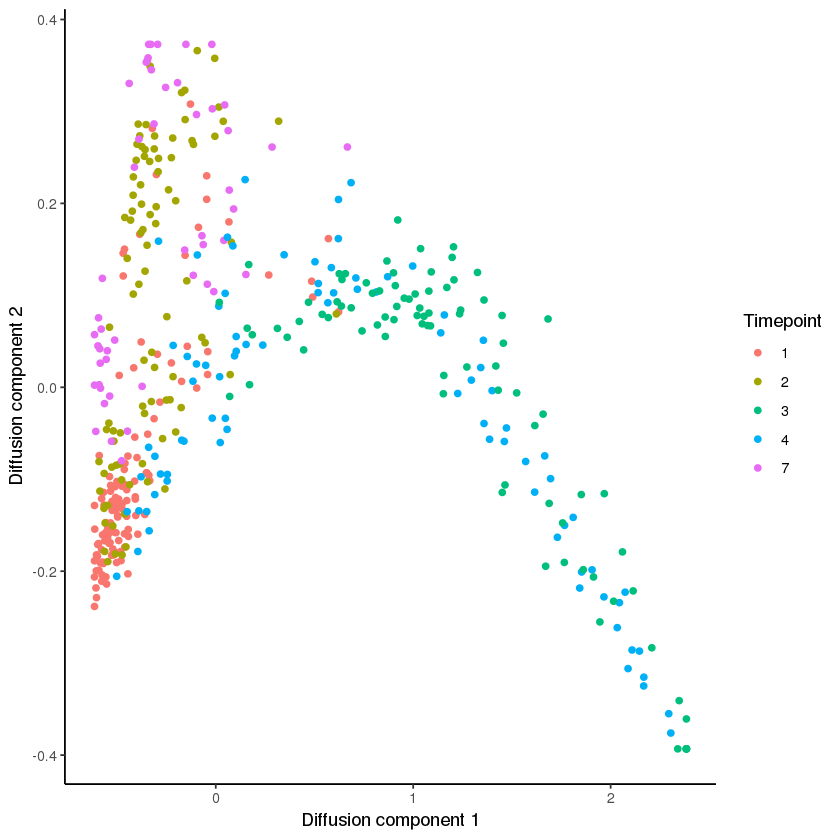

In [11]:
library(ggplot2)
dm=as.data.frame(sub.obj@dr$dm@cell.embeddings)

tmp <- data.frame(DC1 = dm[,1],
                  DC2 = dm[,3],
                  Timepoint =sub.obj@ident)
ggplot(tmp, aes(x = DC1, y = DC2, colour = Timepoint)) +
    geom_point() + scale_color_discrete() + 
    xlab("Diffusion component 1") + 
    ylab("Diffusion component 2") +
    theme_classic()

In [18]:
x=cds.obj
pData(x)$pseudotime_diffusionmap <-rank(dm[,1])

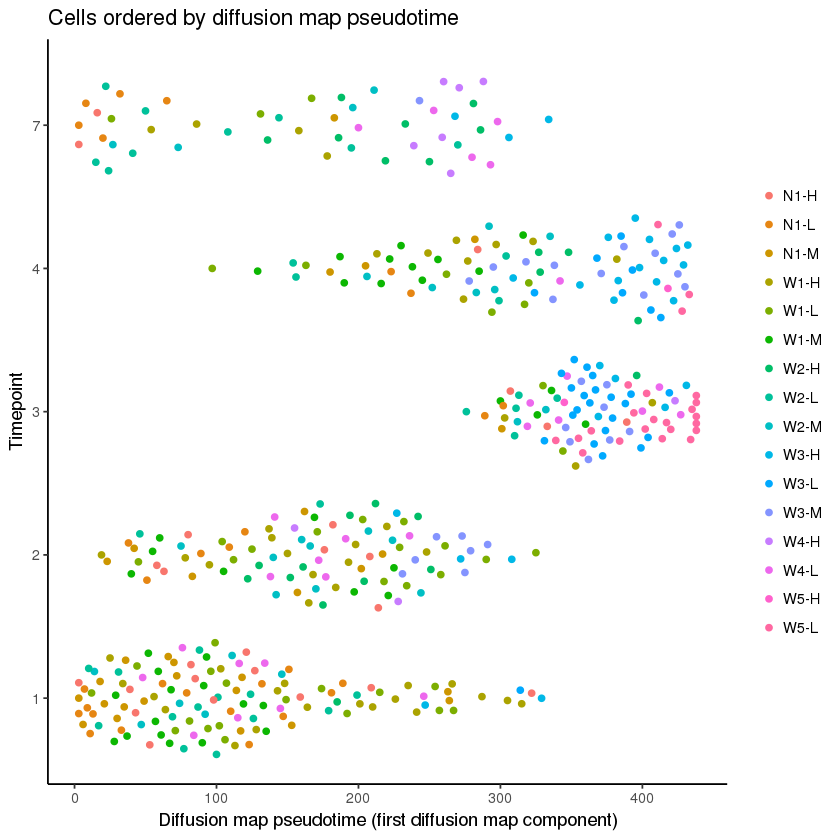

In [13]:
library(ggbeeswarm)
ggplot(data =pData(x) , 
       aes(x = pseudotime_diffusionmap, 
           y =State , colour = group)) +
    geom_quasirandom(groupOnX = FALSE) +
    theme_classic() +
    xlab("Diffusion map pseudotime (first diffusion map component)") +
    ylab("Timepoint") +
    ggtitle("Cells ordered by diffusion map pseudotime")+theme(legend.title = element_blank())

In [4]:
library(Seurat)
library(ggplot2)
library(stringr)
source("tools.R")

In [17]:
genes=c("Ptprj","Rac2","Rac3","Ctnnd1","Ctnnb1",
        "Actn1","Ptpn6","Lmo7","Fyn","Met","Wnt5b",
        "Calm4","Calm5","Fos","Jun","Myc","Tgfa","Erbb2",
       "Araf","Kras","Thbs2","Itga6","Itgb1","Tfrc")
length(genes)
genes=genes[genes%in%rownames(sub.obj@data)]
length(genes)

[1] 24

[1] 23

In [27]:
print(genes)

 [1] "Ptprj"  "Rac3"   "Ctnnd1" "Ctnnb1" "Actn1"  "Ptpn6"  "Lmo7"   "Fyn"   
 [9] "Met"    "Wnt5b"  "Calm4"  "Calm5"  "Fos"    "Jun"    "Myc"    "Tgfa"  
[17] "Erbb2"  "Araf"   "Kras"   "Thbs2"  "Itga6"  "Itgb1" 


In [19]:
x=as.data.frame(as.matrix(pData(x)))
x=cbind(x,as.data.frame(t(as.matrix(sub.obj@data[genes,]))))
x$pseudotime_diffusionmap<-rank(dm[,1])

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


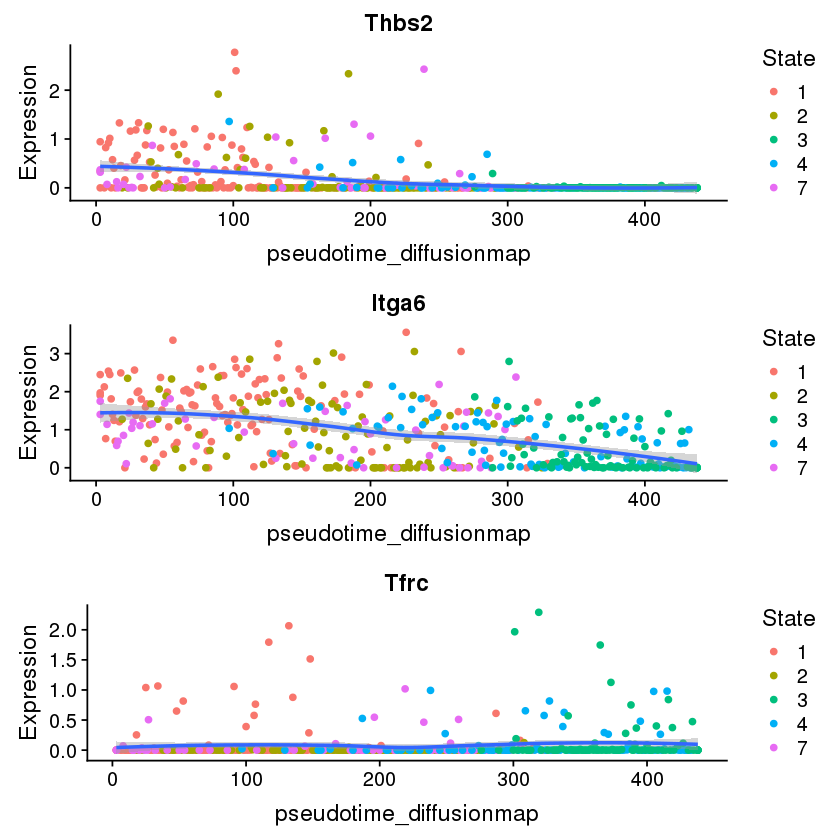

In [20]:
p1<-ggplot(data=x,aes(x=pseudotime_diffusionmap,y=Thbs2))+
         geom_point(aes(colour=State))+geom_smooth()+
         ylab("Expression")+labs(title = "Thbs2")

p2<-ggplot(data=x,aes(x=pseudotime_diffusionmap,y=Itga6))+
         geom_point(aes(colour=State))+geom_smooth()+
         ylab("Expression")+labs(title = "Itga6")

p3<-ggplot(data=x,aes(x=pseudotime_diffusionmap,y=Tfrc))+
         geom_point(aes(colour=State))+geom_smooth()+
         ylab("Expression")+labs(title = "Tfrc")

plot_grid(p1,p2,p3,nrow = 3)

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


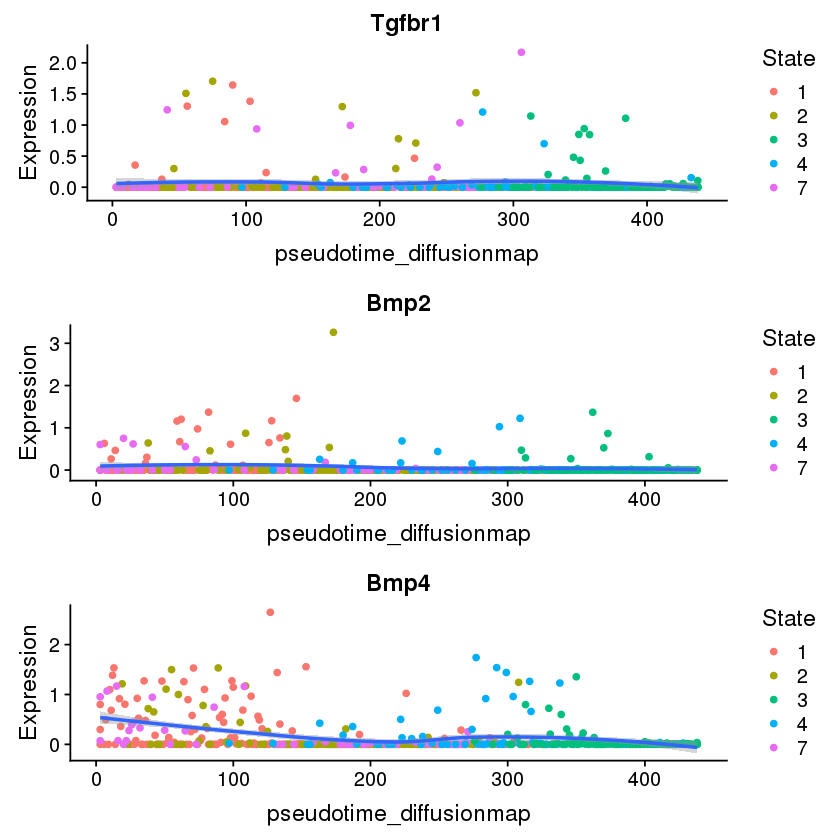

In [92]:
p1<-ggplot(data=x,aes(x=pseudotime_diffusionmap,y=Tgfbr1))+
         geom_point(aes(colour=State))+geom_smooth()+
         ylab("Expression")+labs(title = "Tgfbr1")

p2<-ggplot(data=x,aes(x=pseudotime_diffusionmap,y=Bmp2))+
         geom_point(aes(colour=State))+geom_smooth()+
         ylab("Expression")+labs(title = "Bmp2")

p3<-ggplot(data=x,aes(x=pseudotime_diffusionmap,y=Bmp4))+
         geom_point(aes(colour=State))+geom_smooth()+
         ylab("Expression")+labs(title = "Bmp4")

plot_grid(p1,p2,p3,nrow = 3)

In [88]:
p1<-ggplot(data=x,aes(x=pseudotime_diffusionmap,y=Thbs1))+
         geom_point(aes(colour=State))+geom_smooth()+
         ylab("Expression")+labs(title = "Thbs1")

p2<-ggplot(data=x,aes(x=pseudotime_diffusionmap,y=Top2a))+
         geom_point(aes(colour=State))+geom_smooth()+
         ylab("Expression")+labs(title = "Top2a")

p3<-ggplot(data=x,aes(x=pseudotime_diffusionmap,y=Ube2c))+
         geom_point(aes(colour=State))+geom_smooth()+
         ylab("Expression")+labs(title = "Ube2c")


           

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


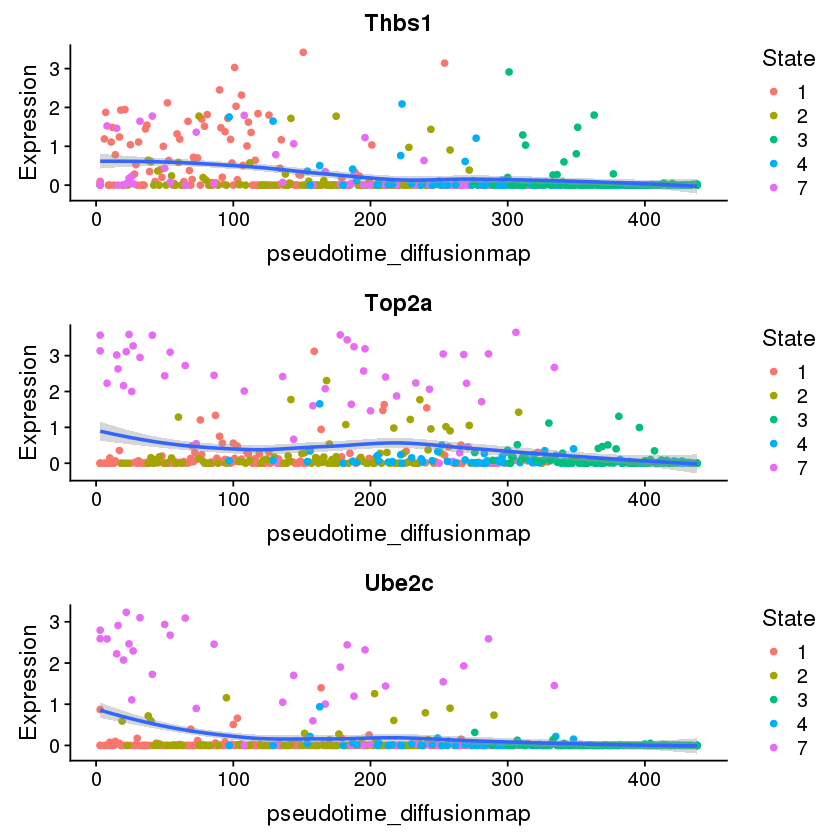

In [89]:
plot_grid(p1,p2,p3,nrow=3)

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


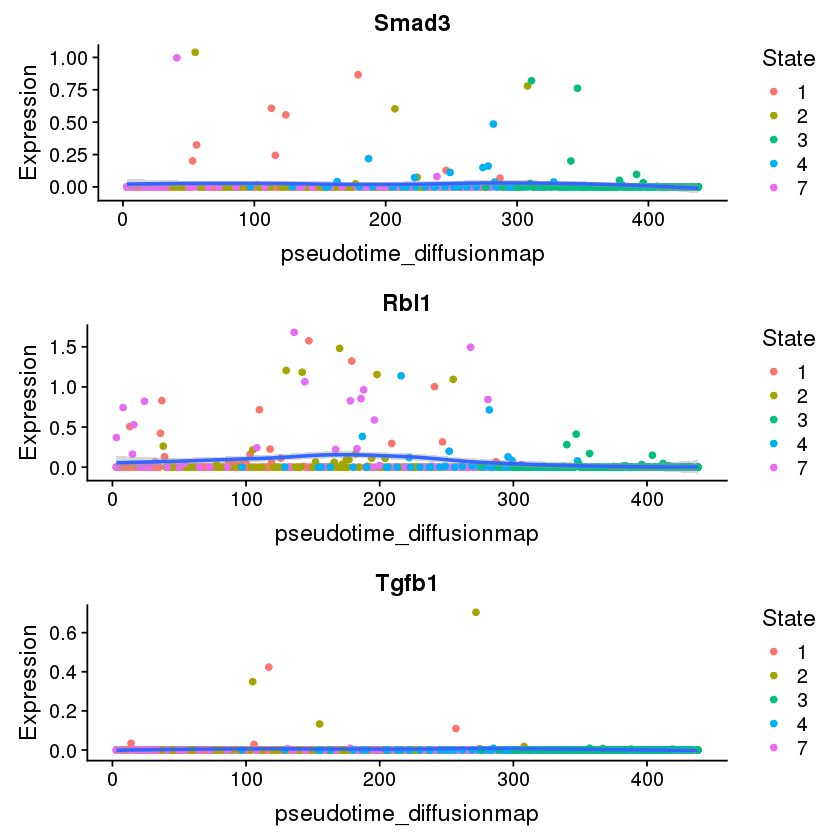

In [93]:

p1<-ggplot(data=x,aes(x=pseudotime_diffusionmap,y=Smad3))+
         geom_point(aes(colour=State))+geom_smooth()+
         ylab("Expression")+labs(title = "Smad3")

p2<-ggplot(data=x,aes(x=pseudotime_diffusionmap,y=Rbl1))+
         geom_point(aes(colour=State))+geom_smooth()+
         ylab("Expression")+labs(title = "Rbl1")

p3<-ggplot(data=x,aes(x=pseudotime_diffusionmap,y=Tgfb1))+
         geom_point(aes(colour=State))+geom_smooth()+
         ylab("Expression")+labs(title = "Tgfb1")

plot_grid(p1,p2,p3,nrow = 3)